# Лабораторна робота 6
## Використання рекурентних нейронних мереж для прогнозування часових рядів і тексту
##### Виконала *Ваховська Віра Миколаївна*

##### Мета:
Вивчити основи роботи з рекурентними нейронними мережами (RNN) на прикладі прогнозування часових рядів та генерування тексту.

## Частина 1: Прогнозування часових рядів

### Крок 1: Імпорт бібліотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

### Крок 2: Завантаження та підготовка даних

In [2]:
data = pd.read_csv('Netflix_Stock_Price.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


| **Назва колонки** | **Опис**                                                                                         |
|--------------------|--------------------------------------------------------------------------------------------------|
| Date              | Дата, до якої відносяться записані дані про ціну акцій                                            |
| Open              | Ціна, за якою акція відкрилася на початку торгового дня                                           |
| High              | Найвища ціна акції протягом торгового дня                                                        |
| Low               | Найнижча ціна акції протягом торгового дня                                                       |
| Close             | Ціна закриття акції, скоригована з урахуванням поділу акцій                                       |
| Adj Close         | Скоригована ціна закриття, враховуючи поділ акцій, дивіденди та/або розподіл капітального доходу |
| Volume            | Обсяг торгів — кількість акцій, якими торгували протягом дня                                      |

Мета даного проєкту — передбачити ціну закриття акцій Netflix на основі даних про торгові дні. Датасет містить історичні дані про ціну акцій Netflix, що включають відкриття, найвищу та найнижчу ціну за день, ціну закриття, скориговану ціну закриття та обсяг торгів.

Цільова ознака: Close — ціна закриття акцій у кінці торгового дня. Вона є основною метою моделювання, оскільки відображає підсумкову ціну акції після завершення всіх торгових операцій.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB


In [4]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


In [5]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# Масштабування даних до діапазону [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Volume', 'Close']].values)

# Параметр глибини історії
look_back = 10  # кількість попередніх днів для передбачення

In [7]:
# Створення послідовностей для тренування
X, y = [], []
for i in range(len(scaled_data) - look_back):
    X.append(scaled_data[i:i + look_back, :-1])  # Використовуємо всі ознаки, окрім 'Close'
    y.append(scaled_data[i + look_back, -1])    # Цільова змінна — 'Close'
X, y = np.array(X), np.array(y)

In [8]:
# Розділення на тренувальні та тестові набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Виведення форми даних
print(f"X_train shape: {X_train.shape}")  # (кількість зразків, look_back, кількість ознак)
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (799, 10, 4)
y_train shape: (799,)
X_test shape: (200, 10, 4)
y_test shape: (200,)


### Крок 3: Створення та навчання моделі

In [10]:
# Загальна функція для створення моделей на основі RNN
def create_rnn_model(model_type, input_shape, num_layers=1, units=50, activation='tanh', output_units=1):
    model = Sequential()
    
    # Додавання RNN-шарів
    RNN_LAYER = {'SimpleRNN': SimpleRNN, 'LSTM': LSTM, 'GRU': GRU}[model_type]
    for i in range(num_layers):
        is_last_layer = (i == num_layers - 1)
        # Вказувати input_shape лише для першого шару
        if i == 0:
            model.add(RNN_LAYER(units, activation=activation, return_sequences=not is_last_layer, input_shape=input_shape))
        else:
            model.add(RNN_LAYER(units, activation=activation, return_sequences=not is_last_layer))
    
    # Додавання вихідного шару
    model.add(Dense(output_units))
    
    # Компіляція моделі
    model.compile(optimizer=Adam(), loss='mse')
    return model

In [11]:
# Експериментальні конфігурації моделі
model_configs = [
    {'type': 'SimpleRNN', 'layers': 1, 'units': 50},
    {'type': 'SimpleRNN', 'layers': 2, 'units': 50},
    {'type': 'SimpleRNN', 'layers': 2, 'units': 100},
    {'type': 'LSTM', 'layers': 1, 'units': 50},
    {'type': 'LSTM', 'layers': 2, 'units': 50},
    {'type': 'LSTM', 'layers': 2, 'units': 100},
    {'type': 'GRU', 'layers': 1, 'units': 50},
    {'type': 'GRU', 'layers': 2, 'units': 50},
    {'type': 'GRU', 'layers': 2, 'units': 100},
]

In [12]:
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "R2 Score": r2
    }

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [14]:
# Навчання моделей
results = {}
trained_models = {}

for config in model_configs:
    model_type = config['type']
    num_layers = config['layers']
    units = config['units']

    print(f"\nTraining {model_type} with {num_layers} layer(s) and {units} units per layer...")

    # Створення моделі
    model = create_rnn_model(
        model_type=model_type,
        input_shape=(look_back, X_train.shape[2]),
        num_layers=num_layers,
        units=units
    )

    # Компіляція моделі
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Навчання моделі
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=2,
        callbacks=[early_stopping]
    )

    # Збереження моделі
    key = f"{model_type}_layers{num_layers}_units{units}"
    trained_models[key] = model
    results[key] = history.history


Training SimpleRNN with 1 layer(s) and 50 units per layer...
Epoch 1/100
25/25 - 2s - loss: 0.0161 - mae: 0.0896 - val_loss: 0.0032 - val_mae: 0.0441 - 2s/epoch - 78ms/step
Epoch 2/100
25/25 - 0s - loss: 0.0037 - mae: 0.0458 - val_loss: 0.0025 - val_mae: 0.0388 - 105ms/epoch - 4ms/step
Epoch 3/100
25/25 - 0s - loss: 0.0027 - mae: 0.0376 - val_loss: 0.0022 - val_mae: 0.0361 - 103ms/epoch - 4ms/step
Epoch 4/100
25/25 - 0s - loss: 0.0023 - mae: 0.0353 - val_loss: 0.0023 - val_mae: 0.0358 - 102ms/epoch - 4ms/step
Epoch 5/100
25/25 - 0s - loss: 0.0020 - mae: 0.0324 - val_loss: 0.0023 - val_mae: 0.0389 - 95ms/epoch - 4ms/step
Epoch 6/100
25/25 - 0s - loss: 0.0018 - mae: 0.0302 - val_loss: 0.0016 - val_mae: 0.0304 - 106ms/epoch - 4ms/step
Epoch 7/100
25/25 - 0s - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0015 - val_mae: 0.0290 - 101ms/epoch - 4ms/step
Epoch 8/100
25/25 - 0s - loss: 0.0015 - mae: 0.0278 - val_loss: 0.0014 - val_mae: 0.0282 - 98ms/epoch - 4ms/step
Epoch 9/100
25/25 - 0s - loss:

### Крок 4: Прогнозування та візуалізація результатів

In [15]:
# Графіки history для однієї моделі (Loss, Mae)
def plot_history(history_dict, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Loss
    axes[0].plot(history_dict['loss'], label='Train', color='blue')
    axes[0].plot(history_dict['val_loss'], label='Validation', color='orange')
    axes[0].set_title(f'{title} - Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Mae
    axes[1].plot(history_dict['mae'], label='Train', color='blue')
    axes[1].plot(history_dict['val_mae'], label='Validation', color='orange')
    axes[1].set_title(f'{title} - MAE')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('MAE')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

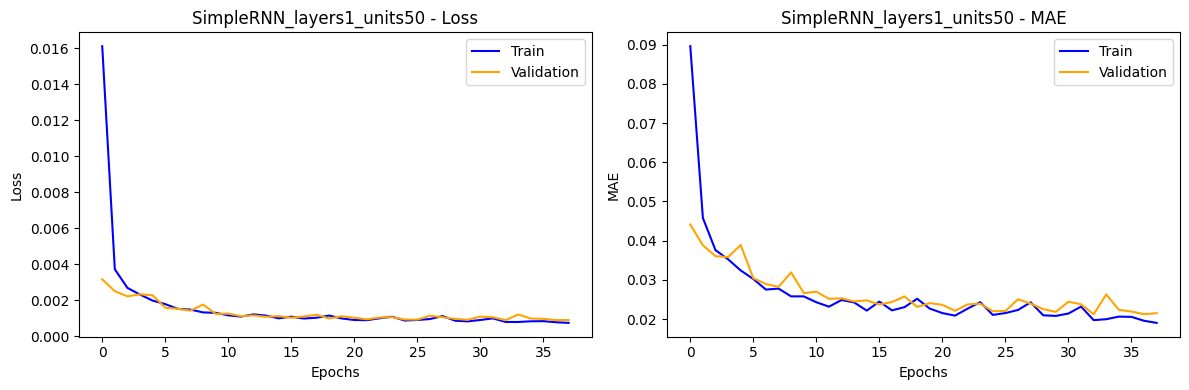

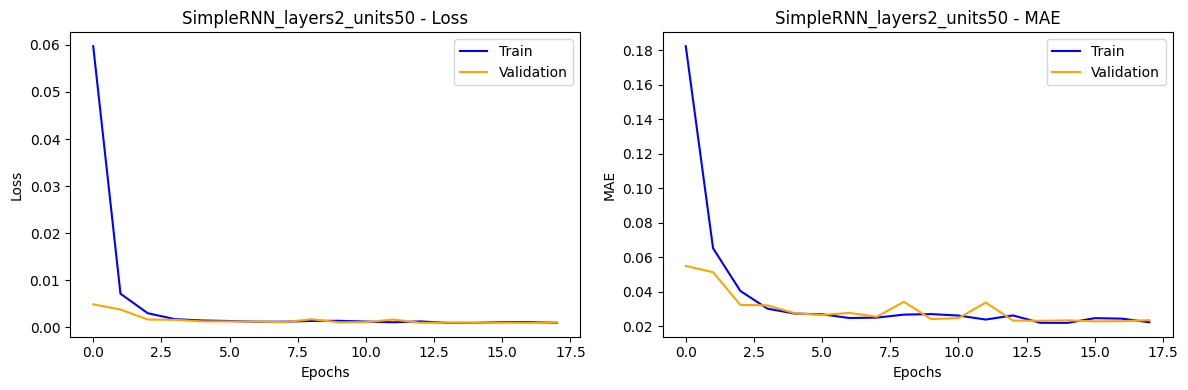

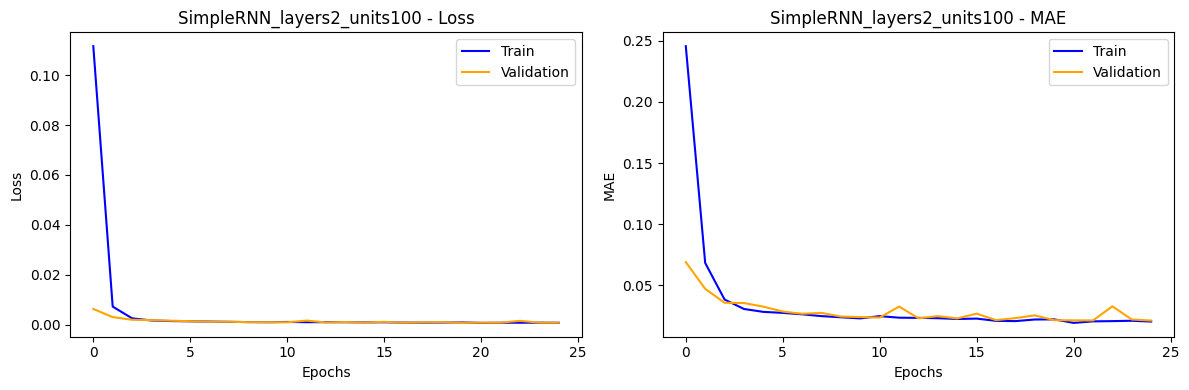

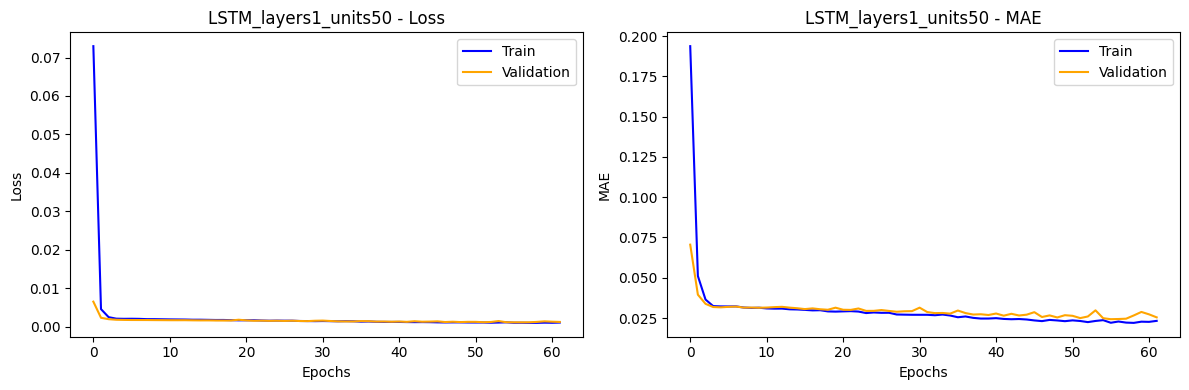

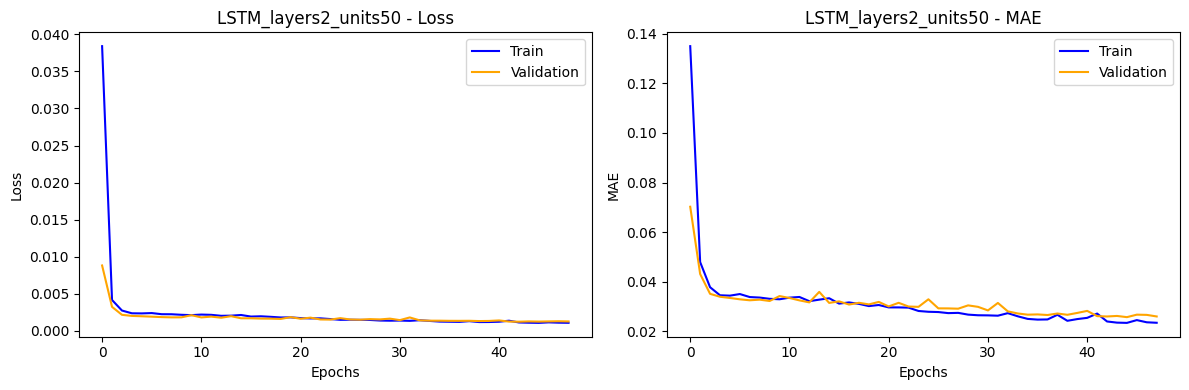

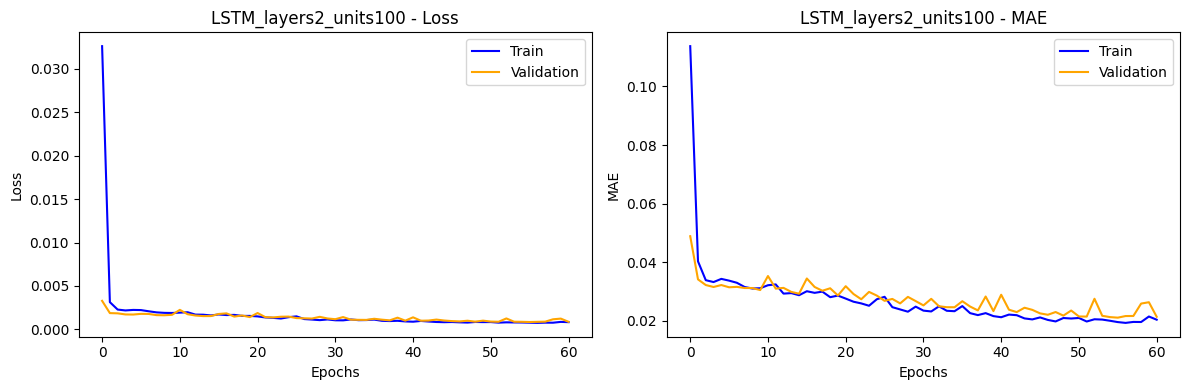

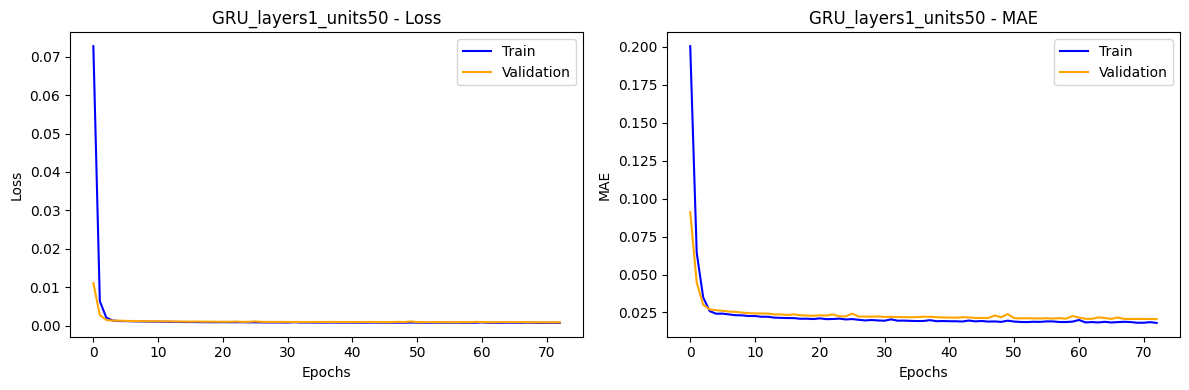

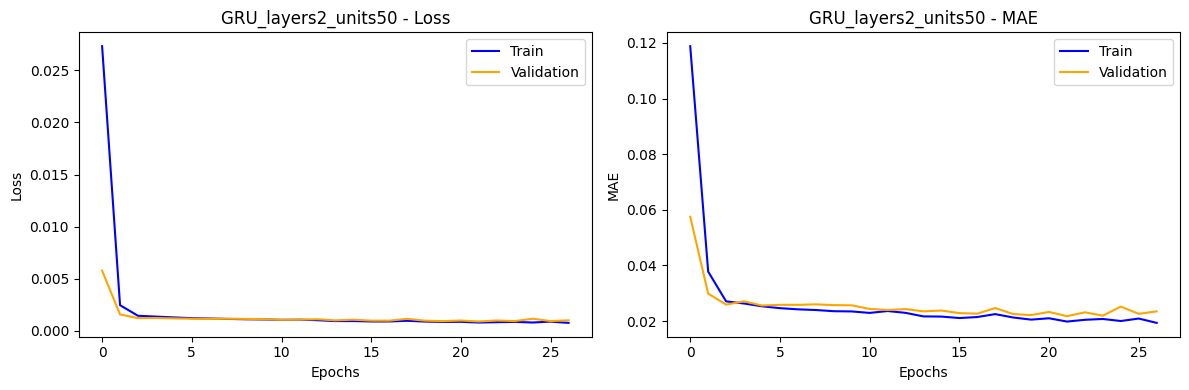

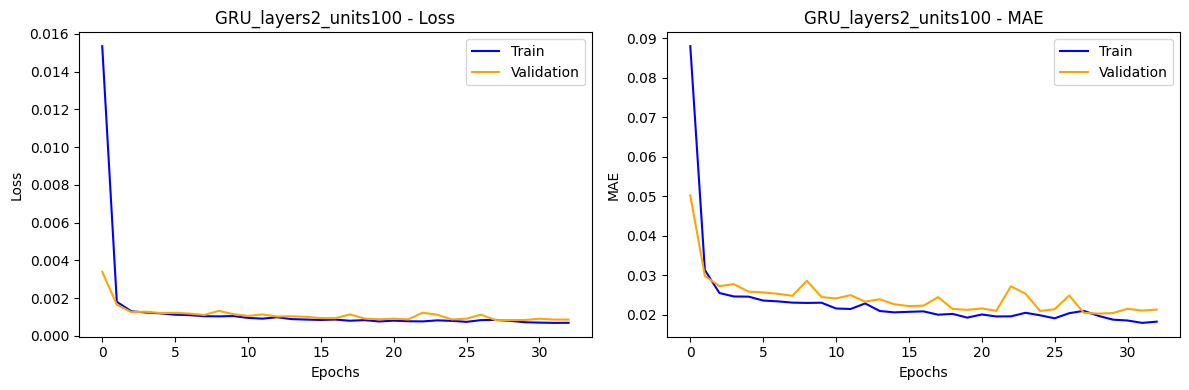

In [16]:
for name, history_dict in results.items():
    plot_history(history_dict, title=name)

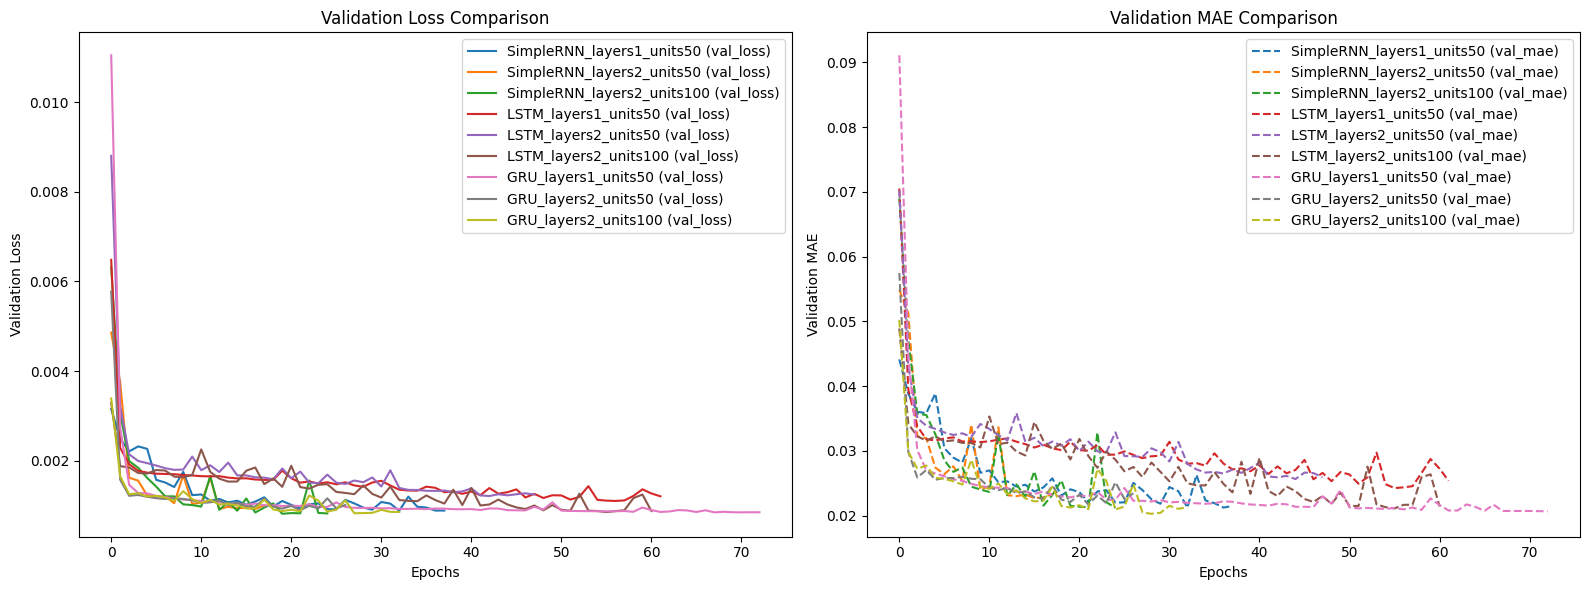

In [18]:
# Створення підграфіків
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 рядок, 2 графіки

# Графік для validation loss
for key, history in results.items():
    axes[0].plot(history['val_loss'], label=f"{key} (val_loss)")
axes[0].set_title('Validation Loss Comparison')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Validation Loss')
axes[0].legend()

# Графік для validation MAE
for key, history in results.items():
    axes[1].plot(history['val_mae'], '--', label=f"{key} (val_mae)")
axes[1].set_title('Validation MAE Comparison')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Validation MAE')
axes[1].legend()

# Відображення графіків
plt.tight_layout()
plt.show()

#### Hold-Out валідація

In [19]:
# Передбачення та оцінка
metrics_results = {}

for model_name, model in trained_models.items():
    y_pred = model.predict(X_test)

    # Масштабування назад
    y_test_original = scaler.inverse_transform(
        np.concatenate([X_test[:, -1, :], y_test.reshape(-1, 1)], axis=1)
    )[:, -1]
    y_pred_original = scaler.inverse_transform(
        np.concatenate([X_test[:, -1, :], y_pred.reshape(-1, 1)], axis=1)
    )[:, -1]

    # Обчислення метрик
    metrics = calculate_metrics(y_test_original, y_pred_original)
    metrics_results[model_name] = metrics

7/7 [==============================] - 1s 4ms/step


In [20]:
# Таблиця результатів
holdout_results = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in metrics_results.items()
])

holdout_results

,Model,MSE,RMSE,MAE,MAPE,R2 Score
0,SimpleRNN_layers1_units50,185.224791,13.609731,9.725657,0.023242,0.984202
1,SimpleRNN_layers2_units50,192.803161,13.885358,10.608896,0.025879,0.983556
2,SimpleRNN_layers2_units100,171.093695,13.080279,9.855910,0.023942,0.985408
3,LSTM_layers1_units50,231.182620,15.204691,11.162238,0.027188,0.980283
4,LSTM_layers2_units50,254.165463,15.942568,11.874604,0.029180,0.978323
5,LSTM_layers2_units100,179.113248,13.383320,9.674530,0.023420,0.984724
6,GRU_layers1_units50,177.735877,13.331762,9.494313,0.022983,0.984841
7,GRU_layers2_units50,187.782322,13.703369,9.952121,0.024298,0.983984
8,GRU_layers2_units100,173.715323,13.180111,9.392318,0.022834,0.985184


#### K-Fold крос-валідація

In [21]:
# K-Fold конфігурація
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Крос-валідація
def cross_validate_model(model_type, num_layers, units, X, y, kf):
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"  Fold {fold + 1}/{k_folds}")

        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        # Клонування моделі
        model_copy = create_rnn_model(
            model_type=model_type,
            input_shape=(X.shape[1], X.shape[2]),
            num_layers=num_layers,
            units=units
        )

        model_copy.compile(optimizer='adam', loss='mse', metrics=['mae'])

        # Тренування моделі з early stopping
        model_copy.fit(
            X_train_fold, y_train_fold,
            epochs=100,
            batch_size=32,
            validation_data=(X_val_fold, y_val_fold),
            verbose=0,
            callbacks=[early_stopping]
        )

        y_pred = model_copy.predict(X_val_fold)

        # Масштабування назад
        y_val_fold_original = scaler.inverse_transform(
            np.concatenate([X_val_fold[:, -1, :], y_val_fold.reshape(-1, 1)], axis=1)
        )[:, -1]
        y_pred_original = scaler.inverse_transform(
            np.concatenate([X_val_fold[:, -1, :], y_pred.reshape(-1, 1)], axis=1)
        )[:, -1]
        
        # Обчислення метрик
        metrics = calculate_metrics(y_val_fold_original, y_pred_original)
        fold_metrics.append(metrics)

    # Середнє значення метрик
    avg_metrics = {key: np.mean([fold[key] for fold in fold_metrics]) for key in fold_metrics[0]}
    
    return avg_metrics

In [22]:
# Оцінка моделей за K-Fold
metrics_kfold_results = {}

for config in model_configs:
    model_type = config['type']
    num_layers = config['layers']
    units = config['units']

    print(f"\nK-Fold Evaluation for {model_type} with {num_layers} layer(s) and {units} units per layer...")
    avg_metrics = cross_validate_model(model_type, num_layers, units, X_train, y_train, kf)
    key = f"{model_type}_layers{num_layers}_units{units}"
    metrics_kfold_results[key] = avg_metrics


K-Fold Evaluation for SimpleRNN with 1 layer(s) and 50 units per layer...
  Fold 1/5
5/5 [==============================] - 0s 2ms/step
  Fold 2/5
5/5 [==============================] - 0s 2ms/step
  Fold 3/5
5/5 [==============================] - 0s 2ms/step
  Fold 4/5
5/5 [==============================] - 0s 1ms/step
  Fold 5/5
5/5 [==============================] - 0s 2ms/step

K-Fold Evaluation for SimpleRNN with 2 layer(s) and 50 units per layer...
  Fold 1/5
5/5 [==============================] - 0s 2ms/step
  Fold 2/5
5/5 [==============================] - 0s 5ms/step
  Fold 3/5
5/5 [==============================] - 0s 2ms/step
  Fold 4/5
5/5 [==============================] - 0s 2ms/step
  Fold 5/5
5/5 [==============================] - 0s 2ms/step

K-Fold Evaluation for SimpleRNN with 2 layer(s) and 100 units per layer...
  Fold 1/5
5/5 [==============================] - 0s 4ms/step
  Fold 2/5
5/5 [==============================] - 0s 2ms/step
  Fold 3/5
5/5 [==============

In [23]:
# Таблиця результатів K-Fold
kfold_results_table = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in metrics_kfold_results.items()
])

kfold_results_table

,Model,MSE,RMSE,MAE,MAPE,R2 Score
0,SimpleRNN_layers1_units50,190.298960,13.529176,9.711182,0.023967,0.983211
1,SimpleRNN_layers2_units50,179.175170,13.171594,9.440649,0.023328,0.984187
2,SimpleRNN_layers2_units100,171.328400,13.014206,9.287868,0.023161,0.984976
3,LSTM_layers1_units50,190.770239,13.640555,9.741704,0.024185,0.983413
4,LSTM_layers2_units50,253.410957,15.401208,11.070845,0.027551,0.978359
5,LSTM_layers2_units100,180.970096,13.286261,9.438707,0.023585,0.984199
6,GRU_layers1_units50,154.954739,12.324526,8.761772,0.021705,0.986429
7,GRU_layers2_units50,151.622451,12.163998,8.587721,0.021347,0.986736
8,GRU_layers2_units100,153.328595,12.267450,8.729803,0.021744,0.986556


In [24]:
# Об'єднання таблиць Hold-out і K-Fold
combined_results = holdout_results.copy()
combined_results.columns = ["Model"] + [f"{col} (Hold-out)" for col in combined_results.columns[1:]]

kfold_results_table.columns = ["Model"] + [f"{col} (K-Fold)" for col in kfold_results_table.columns[1:]]

# Об'єднання по моделі
final_results = pd.merge(combined_results, kfold_results_table, on="Model")

# Сортування колонок, крім "Model"
sorted_columns = ["Model"] + sorted([col for col in final_results.columns if col != "Model"])
final_results = final_results[sorted_columns]

# Закруглення числових колонок до 3 знаків після коми
numerical_columns = final_results.select_dtypes(include=['float', 'int']).columns
final_results[numerical_columns] = final_results[numerical_columns].round(3)

final_results[sorted_columns]

,Model,MAE (Hold-out),MAE (K-Fold),MAPE (Hold-out),MAPE (K-Fold),MSE (Hold-out),MSE (K-Fold),R2 Score (Hold-out),R2 Score (K-Fold),RMSE (Hold-out),RMSE (K-Fold)
0,SimpleRNN_layers1_units50,9.726,9.711,0.023,0.024,185.225,190.299,0.984,0.983,13.610,13.529
1,SimpleRNN_layers2_units50,10.609,9.441,0.026,0.023,192.803,179.175,0.984,0.984,13.885,13.172
2,SimpleRNN_layers2_units100,9.856,9.288,0.024,0.023,171.094,171.328,0.985,0.985,13.080,13.014
3,LSTM_layers1_units50,11.162,9.742,0.027,0.024,231.183,190.770,0.980,0.983,15.205,13.641
4,LSTM_layers2_units50,11.875,11.071,0.029,0.028,254.165,253.411,0.978,0.978,15.943,15.401
5,LSTM_layers2_units100,9.675,9.439,0.023,0.024,179.113,180.970,0.985,0.984,13.383,13.286
6,GRU_layers1_units50,9.494,8.762,0.023,0.022,177.736,154.955,0.985,0.986,13.332,12.325
7,GRU_layers2_units50,9.952,8.588,0.024,0.021,187.782,151.622,0.984,0.987,13.703,12.164
8,GRU_layers2_units100,9.392,8.730,0.023,0.022,173.715,153.329,0.985,0.987,13.180,12.267


In [25]:
# Об'єднання таблиць Hold-out і K-Fold
combined_results1 = holdout_results.copy()
combined_results1.columns = ["Model"] + [f"{col} (Hold-out)" for col in combined_results.columns[1:]]

combined_results2 = kfold_results_table.copy()
combined_results2.columns = ["Model"] + [f"{col} (K-Fold)" for col in combined_results2.columns[1:]]

# Об'єднання по моделі
final_results = pd.merge(combined_results, kfold_results_table, on="Model")

# Сортування колонок, крім "Model"
sorted_columns = ["Model"] + sorted([col for col in final_results.columns if col != "Model"])
final_results = final_results[sorted_columns]

final_results

,Model,MAE (Hold-out),MAE (K-Fold),MAPE (Hold-out),MAPE (K-Fold),MSE (Hold-out),MSE (K-Fold),R2 Score (Hold-out),R2 Score (K-Fold),RMSE (Hold-out),RMSE (K-Fold)
0,SimpleRNN_layers1_units50,9.725657,9.711182,0.023242,0.023967,185.224791,190.298960,0.984202,0.983211,13.609731,13.529176
1,SimpleRNN_layers2_units50,10.608896,9.440649,0.025879,0.023328,192.803161,179.175170,0.983556,0.984187,13.885358,13.171594
2,SimpleRNN_layers2_units100,9.855910,9.287868,0.023942,0.023161,171.093695,171.328400,0.985408,0.984976,13.080279,13.014206
3,LSTM_layers1_units50,11.162238,9.741704,0.027188,0.024185,231.182620,190.770239,0.980283,0.983413,15.204691,13.640555
4,LSTM_layers2_units50,11.874604,11.070845,0.029180,0.027551,254.165463,253.410957,0.978323,0.978359,15.942568,15.401208
5,LSTM_layers2_units100,9.674530,9.438707,0.023420,0.023585,179.113248,180.970096,0.984724,0.984199,13.383320,13.286261
6,GRU_layers1_units50,9.494313,8.761772,0.022983,0.021705,177.735877,154.954739,0.984841,0.986429,13.331762,12.324526
7,GRU_layers2_units50,9.952121,8.587721,0.024298,0.021347,187.782322,151.622451,0.983984,0.986736,13.703369,12.163998
8,GRU_layers2_units100,9.392318,8.729803,0.022834,0.021744,173.715323,153.328595,0.985184,0.986556,13.180111,12.267450


In [26]:
# Знаходимо модель з найменшим MSE (K-Fold)
best_model_name = final_results.loc[final_results["MSE (K-Fold)"].idxmin(), "Model"]
best_model = trained_models[best_model_name]

# Прогноз для тестового набору
y_pred_best = best_model.predict(X_test)

7/7 [==============================] - 0s 3ms/step


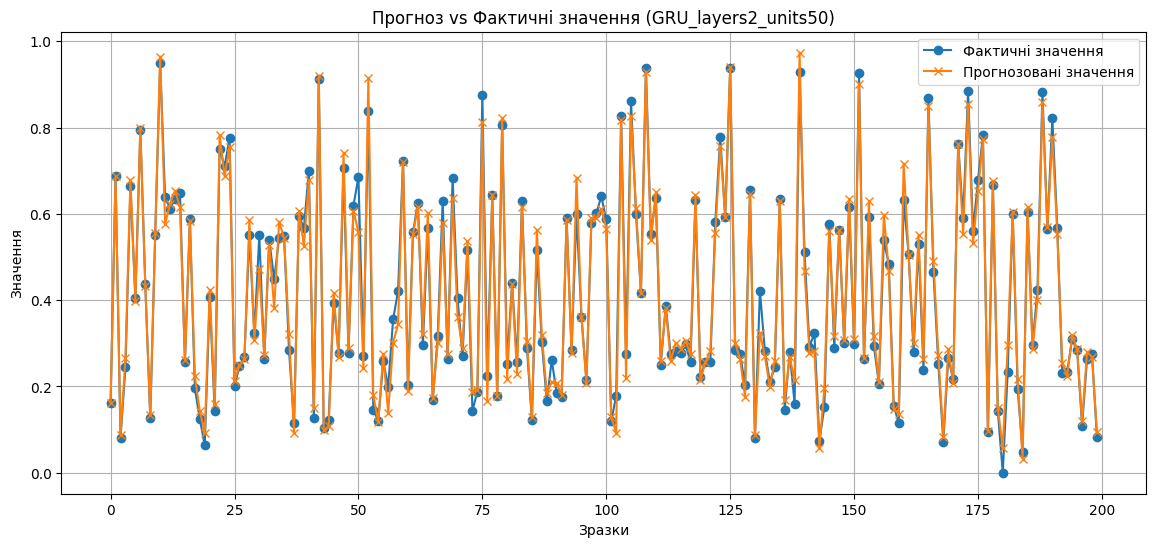

In [27]:
# Масштабування назад для фактичних значень
y_test_original = scaler.inverse_transform(
    np.concatenate([X_test[:, -1, :], y_test.reshape(-1, 1)], axis=1)
)[:, -1]

# Масштабування назад для прогнозованих значень
y_pred_best_original = scaler.inverse_transform(
    np.concatenate([X_test[:, -1, :], y_pred_best.reshape(-1, 1)], axis=1)
)[:, -1]

# Побудова графіку
plt.figure(figsize=(14, 6))
plt.plot(y_test, label="Фактичні значення", marker='o')
plt.plot(y_pred_best, label="Прогнозовані значення", marker='x')
plt.title(f"Прогноз vs Фактичні значення ({best_model_name})")
plt.xlabel("Зразки")
plt.ylabel("Значення")
plt.legend()
plt.grid(True)
plt.show()

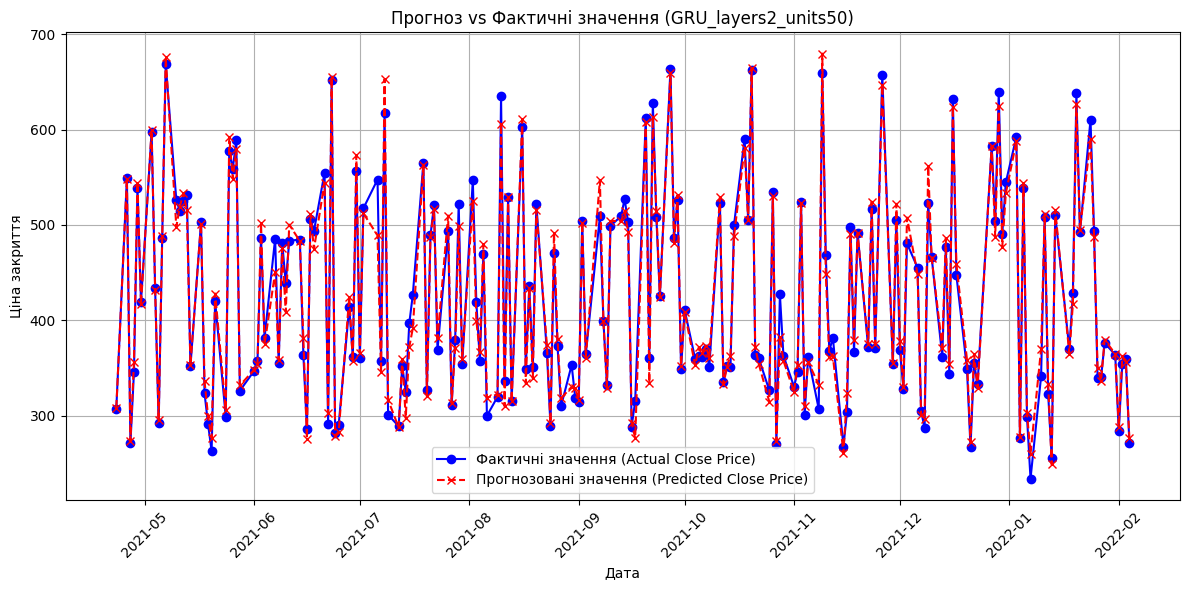

In [28]:
# Відновлення масштабів тільки для 'Close'
y_test_rescaled = scaler.inverse_transform(
    np.hstack((np.zeros((len(y_test), scaled_data.shape[1] - 1)), y_test.reshape(-1, 1)))
)[:, -1]

y_pred_rescaled = scaler.inverse_transform(
    np.hstack((np.zeros((len(y_pred_best), scaled_data.shape[1] - 1)), y_pred_best.reshape(-1, 1)))
)[:, -1]

# Дати для тестового набору
test_dates = pd.to_datetime(data['Date']).iloc[-len(y_test):]

# Побудова графіку
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_rescaled, label="Фактичні значення (Actual Close Price)", marker='o', linestyle='-', color='blue')
plt.plot(test_dates, y_pred_rescaled, label="Прогнозовані значення (Predicted Close Price)", marker='x', linestyle='--', color='red')
plt.title(f"Прогноз vs Фактичні значення ({best_model_name})")
plt.xlabel("Дата")
plt.ylabel("Ціна закриття")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Глибина історії (look_back)

In [29]:
def experiment_with_look_back(look_back_values, model_config, data, scaler):
    results = {}

    for look_back in look_back_values:
        print(f"\nТестування з look_back={look_back}...")

        # Масштабування даних
        scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Volume', 'Close']].values)

        # Формування послідовностей
        X, y = [], []
        for i in range(len(scaled_data) - look_back):
            X.append(scaled_data[i:i + look_back, :-1])  # Всі ознаки, окрім 'Close'
            y.append(scaled_data[i + look_back, -1])    # Цільова змінна — 'Close'
        X, y = np.array(X), np.array(y)

        # Розділення на тренувальні та тестові набори
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Створення моделі
        model = create_rnn_model(
            model_type=model_config['type'],
            input_shape=(look_back, X_train.shape[2]),
            num_layers=model_config['layers'],
            units=model_config['units']
        )

        # Навчання моделі
        history = model.fit(
            X_train, y_train,
            epochs=100,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=0,
            callbacks=[early_stopping]
        )

        # Прогнозування
        y_pred = model.predict(X_test)

        # Масштабування назад
        y_test_original = scaler.inverse_transform(
            np.concatenate([X_test[:, -1, :], y_test.reshape(-1, 1)], axis=1)
        )[:, -1]

        y_pred_original = scaler.inverse_transform(
            np.concatenate([X_test[:, -1, :], y_pred.reshape(-1, 1)], axis=1)
        )[:, -1]

        # Оцінка моделі
        metrics = calculate_metrics(y_test_original, y_pred_original)

        # Збереження результатів
        results[look_back] = metrics

    return results

In [30]:
# Визначення параметрів експерименту
look_back_values = [5, 10, 15, 20, 30, 50, 100, 500]
model_config = {
    'type': 'SimpleRNN',
    'layers': 1,
    'units': 50
}

# Запуск експерименту
look_back_results = experiment_with_look_back(look_back_values, model_config, data, scaler)


Тестування з look_back=5...
7/7 [==============================] - 0s 1ms/step

Тестування з look_back=10...
7/7 [==============================] - 0s 2ms/step

Тестування з look_back=15...
7/7 [==============================] - 0s 2ms/step

Тестування з look_back=20...
7/7 [==============================] - 0s 2ms/step

Тестування з look_back=30...
7/7 [==============================] - 0s 2ms/step

Тестування з look_back=50...
6/6 [==============================] - 0s 3ms/step

Тестування з look_back=100...
6/6 [==============================] - 0s 10ms/step

Тестування з look_back=500...
4/4 [==============================] - 0s 16ms/step


In [31]:
# Таблиця результатів
look_back_results_table = pd.DataFrame.from_dict(look_back_results, orient='index')
look_back_results_table.index.name = 'look_back'
look_back_results_table.reset_index(inplace=True)

look_back_results_table

,look_back,MSE,RMSE,MAE,MAPE,R2 Score
0,5,142.494700,11.937114,7.865797,0.019424,0.988396
1,10,173.877576,13.186265,9.321431,0.022489,0.985170
2,15,176.211897,13.274483,10.074320,0.024079,0.984953
3,20,156.240298,12.499612,9.230627,0.022773,0.986211
4,30,221.330972,14.877196,9.441981,0.022557,0.978814
5,50,216.012053,14.697349,10.041104,0.023402,0.981099
6,100,172.343378,13.127962,9.741260,0.024555,0.984941
7,500,173.717029,13.180176,9.864816,0.020003,0.973615


## Частина 2: Генерація тексту

### Крок 1: Імпорт бібліотек

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string, os 
import re

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

### Крок 2: Підготовка текстових даних

In [33]:
data2 = pd.read_csv('en_songs.csv')
data2.head()

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


In [34]:
df_lyrics = data2[['Lyrics']]
df_lyrics.head()

,Lyrics
0,"Vintage tee, brand new phone\nHigh heels on co..."
1,"I can see you standing, honey\nWith his arms a..."
2,We could leave the Christmas lights up 'til Ja...
3,"I'm doing good, I'm on some new shit\nBeen say..."
4,I don't like your little games\nDon't like you...


In [36]:
df_lyrics.loc[:, 'Number_of_words'] = df_lyrics['Lyrics'].apply(lambda x: len(str(x).split()))
df_lyrics.head()

,Lyrics,Number_of_words
0,"Vintage tee, brand new phone\nHigh heels on co...",337
1,"I can see you standing, honey\nWith his arms a...",459
2,We could leave the Christmas lights up 'til Ja...,259
3,"I'm doing good, I'm on some new shit\nBeen say...",308
4,I don't like your little games\nDon't like you...,558


In [37]:
df_lyrics['Number_of_words'].describe()

count     745.000000
mean      276.260403
std       129.230505
min         1.000000
25%       189.000000
50%       255.000000
75%       340.000000
max      1386.000000
Name: Number_of_words, dtype: float64

In [38]:
df_lyrics = df_lyrics[df_lyrics['Number_of_words'] > 5]

In [39]:
df_lyrics['Number_of_words'].describe()

count     744.000000
mean      276.630376
std       128.922021
min        23.000000
25%       189.000000
50%       255.500000
75%       340.000000
max      1386.000000
Name: Number_of_words, dtype: float64

In [40]:
df_lyrics_5 = df_lyrics.sample(n=5, random_state=42)

In [41]:
df_lyrics_5['Number_of_words'].describe()

count      5.000000
mean     291.400000
std       56.100802
min      208.000000
25%      271.000000
50%      298.000000
75%      325.000000
max      355.000000
Name: Number_of_words, dtype: float64

In [42]:
def clean_text(text):
    # text = text.lower()
    text = re.sub("[^A-Za-z0-9'\.\?!\n ]", "", text)
    text = text.replace('\n', ' ')
    text = re.sub(" +", " ", text)
    return text.strip()

df_lyrics_5['Cleaned_Lyrics'] = df_lyrics['Lyrics'].apply(clean_text)
df_lyrics_5

,Lyrics,Number_of_words,Cleaned_Lyrics
609,"Today, while the blossoms still cling to the v...",208,Today while the blossoms still cling to the vi...
539,I could take the high road\nBut I know that I'...,298,I could take the high road But I know that I'm...
695,"It's getting late, have you seen my mates?\nMa...",325,It's getting late have you seen my mates? Ma t...
350,I'm so gone\nAnyone could see that I'm wasted\...,271,I'm so gone Anyone could see that I'm wasted Y...
174,Time - He's waiting in the wings\nHe speaks of...,355,Time He's waiting in the wings He speaks of se...


In [43]:
# Перевірити на наявність певного патерну
noise_pattern = r'\bhistory24embedshare\b|\burlcopyembedcopy\b'
noise_count = df_lyrics_5['Cleaned_Lyrics'].str.contains(noise_pattern, regex=True).sum()
print(f"Кількість знайдених патернів: {noise_count}")

# Видалити цей патерн
if noise_count > 0:
    df_lyrics_5['Cleaned_Lyrics'] = df_lyrics_5['Cleaned_Lyrics'].apply(
        lambda x: re.sub(noise_pattern, '', x)
    )
    print("Видалено шуми")
else:
    print("Шуми не знайдені")

Кількість знайдених патернів: 0
Шуми не знайдені


In [44]:
# Об'єднання очищених текстів пісень для токенізації
text = ' '.join(df_lyrics_5['Cleaned_Lyrics'].tolist())
print("Довжина тексту: ", len(text))

Довжина тексту:  7113


In [45]:
# Токенізація
tokenizer = Tokenizer()  # Ліміт (num_words=100)
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1

In [46]:
# Створення послідовностей
input_sequences = []
for line in text.split('.'):  # Поділ за реченнями для отримання осмислених послідовностей
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [47]:
# Падінг послідовностей
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre')

In [48]:
# Поділ на вхідні та вихідні дані
X, y = input_sequences[:, :-1], input_sequences[:, -1]
y = tf.keras.utils.to_categorical(y, num_classes=len(tokenizer.word_index) + 1)

### Крок 3: Створення та навчання моделі

In [49]:
# Функція для створення моделі на основі конфігурації
def create_text_generation_model(total_words, max_sequence_len, embedding_dim, rnn_type, num_layers, units_per_layer):
    model = Sequential()
    model.add(Embedding(total_words, embedding_dim, input_length=max_sequence_len - 1))

    RNN_LAYER = {'LSTM': LSTM, 'GRU': GRU}[rnn_type]
    
    # Додавання рекурентних шарів
    for i in range(num_layers):
        is_last_layer = (i == num_layers - 1)
        model.add(RNN_LAYER(units_per_layer, return_sequences=not is_last_layer))

    # Додавання вихідного шару
    model.add(Dense(total_words, activation='softmax'))
    return model

In [50]:
# Визначення конфігурацій моделей
model_configs = [
    {'rnn_type': 'LSTM', 'embedding_dim': 100, 'num_layers': 1, 'units_per_layer': 150, 'epochs': 30},
    {'rnn_type': 'LSTM', 'embedding_dim': 200, 'num_layers': 2, 'units_per_layer': 100, 'epochs': 40},
    {'rnn_type': 'GRU',  'embedding_dim': 150, 'num_layers': 1, 'units_per_layer': 200, 'epochs': 50},
    {'rnn_type': 'GRU',  'embedding_dim': 100, 'num_layers': 2, 'units_per_layer': 150, 'epochs': 30},
]

In [51]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [52]:
trained_models = {}

for config in model_configs:
    print(f"\nTraining {config['rnn_type']} model with {config['num_layers']} layer(s), "
          f"{config['units_per_layer']} units/layer, embedding size {config['embedding_dim']}...")
    
    # Створення та компіляція моделі
    model = create_text_generation_model(
        total_words=total_words,
        max_sequence_len=max_sequence_len,
        embedding_dim=config['embedding_dim'],
        rnn_type=config['rnn_type'],
        num_layers=config['num_layers'],
        units_per_layer=config['units_per_layer']
    )
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # Навчання моделі
    history = model.fit(
        X, y, 
        epochs=config['epochs'], 
        batch_size=32, 
        verbose=1, 
        callbacks=[early_stopping]
    )
    
    # Збереження моделі та історії навчання
    key = f"{config['rnn_type']}_layers{config['num_layers']}_units{config['units_per_layer']}_embedding{config['embedding_dim']}"
    trained_models[key] = (model, history)


Training LSTM model with 1 layer(s), 150 units/layer, embedding size 100...
Epoch 1/30
46/46 [==============================] - 37s 712ms/step - loss: 5.5938
Epoch 2/30
46/46 [==============================] - 36s 790ms/step - loss: 5.0483
Epoch 3/30
46/46 [==============================] - 36s 776ms/step - loss: 4.7478
Epoch 4/30
46/46 [==============================] - 36s 776ms/step - loss: 4.4989
Epoch 5/30
46/46 [==============================] - 39s 850ms/step - loss: 4.2495
Epoch 6/30
46/46 [==============================] - 39s 841ms/step - loss: 4.0294
Epoch 7/30
46/46 [==============================] - 40s 866ms/step - loss: 3.7583
Epoch 8/30
46/46 [==============================] - 34s 741ms/step - loss: 3.4994
Epoch 9/30
46/46 [==============================] - 34s 738ms/step - loss: 3.2249
Epoch 10/30
46/46 [==============================] - 34s 744ms/step - loss: 2.9584
Epoch 11/30
46/46 [==============================] - 34s 737ms/step - loss: 2.7017
Epoch 12/30
46/46 [

In [53]:
for key, (model, history) in trained_models.items():
    print(f"\nModel: {key}")
    print(f"History keys: {list(history.history.keys())}")


Model: LSTM_layers1_units150_embedding100
History keys: ['loss']

Model: LSTM_layers2_units100_embedding200
History keys: ['loss']

Model: GRU_layers1_units200_embedding150
History keys: ['loss']

Model: GRU_layers2_units150_embedding100
History keys: ['loss']


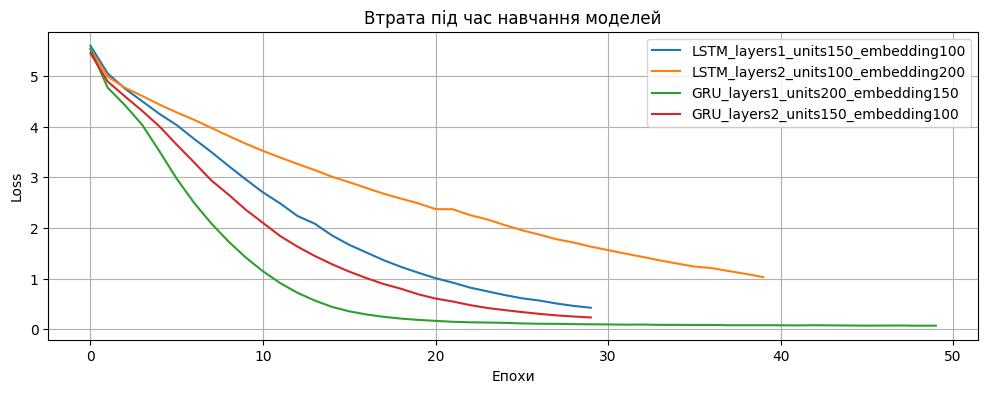

In [54]:
# Візуалізація втрати
plt.figure(figsize=(12, 4))
for key, (model, history) in trained_models.items():
    plt.plot(history.history['loss'], label=f"{key}")

plt.title("Втрата під час навчання моделей")
plt.xlabel("Епохи")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Генерація тексту на основі початкового тексту та конфігурації моделі
def generate_text(seed_text, next_words, model, max_sequence_len, tokenizer):
    for _ in range(next_words):
        # Токенізація початкового тексту
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        
        # Доповнення токенізованої послідовності до потрібної довжини
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        
        # Прогнозування наступного слова на основі токенів
        predicted = model.predict(token_list, verbose=0)
        predicted_word_index = np.argmax(predicted, axis=1)
        
        # Перетворення індексу в слово за допомогою словника токенізатора
        predicted_word = tokenizer.index_word.get(predicted_word_index[0], '')
        
        # Додавання спрогнозованого слова до початкового тексту
        seed_text += " " + predicted_word

    return seed_text

### Крок 4: Генерація тексту

In [56]:
# Генерація тексту для кількох моделей
def generate_text_for_models(seed_text, next_words, trained_models, max_sequence_len, tokenizer):
    results = []

    # Прохід по всіх навчених моделях
    for model_key, (model, _) in trained_models.items():
        # Генерація тексту за допомогою моделі
        generated_text = generate_text(seed_text, next_words, model, max_sequence_len, tokenizer)
        
        # Збереження моделі та згенерованого тексту
        results.append([model_key, generated_text])

    # Створення таблиці результатів
    df = pd.DataFrame(results, columns=["Model", "Generated Text"])
    return df

In [57]:
# Налаштування
next_words = 50
max_sequence_len = max([len(x) for x in input_sequences])
pd.set_option('display.max_colwidth', None)

In [58]:
df = generate_text_for_models("And the sky is grey", next_words, trained_models, max_sequence_len, tokenizer)
df

,Model,Generated Text
0,LSTM_layers1_units150_embedding100,And the sky is grey you're you're and i'll left your coat behind take your the up is hard but is hateful i had so many dreams i had so many breakthroughs but you my love were kind but love has left you dreamless the door to dreams was closed your park was real and
1,LSTM_layers2_units100_embedding200,And the sky is grey you're you're you'll you'll and you'll who and who am i on by now we should be on by now we should be on by now we li li li li li li li li li li li li li li li li li li li li li li li
2,GRU_layers1_units200_embedding150,And the sky is grey blossoms still cling to the vine i'll taste your strawberries i'll drink your sweet wine a million tomorrows shall all pass away 'ere i forget all the joy that is mine today i could take the high road but i know that i'm goin' low i'm a bani'm a bandito
3,GRU_layers2_units150_embedding100,And the sky is grey story i'll laugh and i'll cry and i'll sing today while the blossoms still cling to the vine i'll taste your strawberries i'll drink your sweet wine a million tomorrows shall all pass away 'ere i forget all the joy that is mine today i could take the high road


In [59]:
df = generate_text_for_models("I'm afraid of", next_words, trained_models, max_sequence_len, tokenizer)
df

,Model,Generated Text
0,LSTM_layers1_units150_embedding100,I'm afraid of while the blossoms still cling to the vine i'll taste your strawberries i'll drink your sweet wine a million tomorrows shall all pass away 'ere i forget all the joy that is mine today i can't be contented with yesterday's glory i can't live on promises winter to spring today
1,LSTM_layers2_units100_embedding200,I'm afraid of be by goddamn you're you'll you'll and you'll and who if if i want on on now it on now it it on now lay it on me now lay it all on me now lay it all on me now lay it all on me now lay it all
2,GRU_layers1_units200_embedding150,I'm afraid of be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on
3,GRU_layers2_units150_embedding100,I'm afraid of today i'll the sing i'll cry and i'll sing today while the blossoms still cling to the vine i'll taste your strawberries i'll drink your sweet wine a million tomorrows shall all pass away 'ere i forget all the joy that is mine today i could take the high road


In [60]:
next_words = 100

In [61]:
df = generate_text_for_models("I wish you", next_words, trained_models, max_sequence_len, tokenizer)
df

,Model,Generated Text
0,LSTM_layers1_units150_embedding100,I wish you should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by
1,LSTM_layers2_units100_embedding200,I wish you goddamn goddamn looking old freeze to catch a catch it to your cold your vain your vain me me out who who all i all so all oh baby baby will all all on on now on now it on me now lay it all on me now lay it all on me now lay it all on me now lay it all on me now lay it all on me now lay it all on me now lay it all on me now lay it all on me now lay it all on me now lay it all on
2,GRU_layers1_units200_embedding150,I wish you live on a piece of paper honey mmm put it in my coat before i go hidden in a place you know i'll find it oh ohh later when i'm sitting all alone let me in everything starts at your skin so new your love's always finding me out who am i kidding if all my defences come down oh baby yeah will you lay it all on me now lay it all on me now lay it all on me now lay it all on me now lay it all on me now lay it all on me now
3,GRU_layers2_units150_embedding100,I wish you on promises winter to spring today is my moment now is my story i'll laugh and i'll cry and i'll sing today while the blossoms still cling to the vine i'll taste your strawberries i'll drink your sweet wine a million tomorrows shall all pass away 'ere i forget all the joy that is mine today i could take the high road but i know that i'm goin' low i'm a bani'm a bandito i could take the high road but i know that i'm goin' low i'm a bani'm a bandito i could take the high road but i


In [62]:
df = generate_text_for_models("I love the", next_words, trained_models, max_sequence_len, tokenizer)
df

,Model,Generated Text
0,LSTM_layers1_units150_embedding100,I love the goddamn you're looking old you'll freeze and catch a cold 'cause you've left your coat behind take your time breaking up is hard but keeping dark is hateful i had so many dreams i had so many breakthroughs but you my love were kind but love has left you dreamless the door to dreams was closed your park was real and dreamless perhaps you're smiling now smiling through this darkness but all i have to give is guilt for dreaming we should be on by now we should be on by now we should be on by now we should
1,LSTM_layers2_units100_embedding200,I love the you're you'll you'll you'll and i'll who i sing today while the blossoms still cling to the vine i'll taste your strawberries i'll drink your sweet wine a million tomorrows shall all pass away 'ere i forget all the joy that is mine today i could take the high road but i know that i'm goin' low i'm a bani'm a bandito i could take the high road but i know that i'm goin' low i'm a bani'm a bandito i could take the high road but i know that i'm goin' low i'm a bani'm a bandito i could
2,GRU_layers1_units200_embedding150,I love the sniper in the brain regurgitating drain incestuous and vain and many other last names well i look at my watch it says 925 and i think oh god i'm still alive to be i could take the high road but i know that i'm goin' low i'm a bani'm a bandito i could take the high road but i know that i'm goin' low i'm a bani'm a bandito i could take the high road but i know that i'm goin' low i'm a bani'm a bandito i could take the high road but i know that i'm goin' low
3,GRU_layers2_units150_embedding100,I love the proof could you on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on


In [63]:
df = generate_text_for_models("Love is", next_words, trained_models, max_sequence_len, tokenizer)
df

,Model,Generated Text
0,LSTM_layers1_units150_embedding100,Love is goddamn you're looking old you'll freeze and catch a cold 'cause you've left your coat behind take your time breaking up is hard but keeping dark is hateful i had so many dreams i had so many breakthroughs but you my love were kind but love has left you dreamless the door to dreams was closed your park was real and dreamless perhaps you're smiling now smiling through this darkness but all i have to give is guilt for dreaming we should be on by now we should be on by now we should be on by now we should
1,LSTM_layers2_units100_embedding200,Love is be be goddamn goddamn looking old freeze to catch to catch a cold it and and vain and many last last look of well of at and other other says and 925 and i think i time i alive regurgitating incestuous and vain and many last names it i think i watch you says and 925 and i think i god i'm still still still to to to fear's a rival or close relative to truth either way it helps to hear these words bounce off of the the softest echo time is is my dark my dark my old
2,GRU_layers1_units200_embedding150,Love is you know i'll be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be on by now we should be
3,GRU_layers2_units150_embedding100,Love is you're you're you're freeze and red it's you'll catch a cold 'cause you've left your coat behind take your time breaking up is hard but keeping dark is hateful i had so many dreams i had so many breakthroughs but you my love were kind but love has left you dreamless the door to dreams was closed your park was real and dreamless perhaps you're smiling now smiling through this darkness but all i have to give is guilt for dreaming we should be on by now we should be on by now we should be on by now we


### Додатково: збереження моделей (+history) після навчання

In [64]:
save_dir = "saved_models"
os.makedirs(save_dir, exist_ok=True)

for key, (model, history) in trained_models.items():
    model_path = os.path.join(save_dir, f"{key}.h5")
    model.save(model_path)
    print(f"Модель {key} збережена - {model_path}")

Модель LSTM_layers1_units150_embedding100 збережена - saved_models\LSTM_layers1_units150_embedding100.h5
Модель LSTM_layers2_units100_embedding200 збережена - saved_models\LSTM_layers2_units100_embedding200.h5
Модель GRU_layers1_units200_embedding150 збережена - saved_models\GRU_layers1_units200_embedding150.h5
Модель GRU_layers2_units150_embedding100 збережена - saved_models\GRU_layers2_units150_embedding100.h5


```python
from tensorflow.keras.models import load_model

save_dir = "saved_models"

loaded_models = {}
for key in os.listdir(save_dir):
    if key.endswith(".h5"):
        model_path = os.path.join(save_dir, key)
        loaded_models[key] = load_model(model_path)
        print(f"Моделы завантажені з {model_path}")

In [66]:
import json

for key, (model, history) in trained_models.items():
    history_path = os.path.join(save_dir, f"{key}_history.json")
    with open(history_path, "w") as f:
        json.dump(history.history, f)
    print(f"History для {key} збережена - {history_path}")

History для LSTM_layers1_units150_embedding100 збережена - saved_models\LSTM_layers1_units150_embedding100_history.json
History для LSTM_layers2_units100_embedding200 збережена - saved_models\LSTM_layers2_units100_embedding200_history.json
History для GRU_layers1_units200_embedding150 збережена - saved_models\GRU_layers1_units200_embedding150_history.json
History для GRU_layers2_units150_embedding100 збережена - saved_models\GRU_layers2_units150_embedding100_history.json


```python
loaded_histories = {}
for key in os.listdir(save_dir):
    if key.endswith("_history.json"):
        history_path = os.path.join(save_dir, key)
        with open(history_path, "r") as f:
            loaded_histories[key] = json.load(f)
        print(f"Завантажені history з {history_path}")

## Висновки

У ході виконання лабораторної роботи було виконано два завдання.

У межах першого завдання було здійснено прогнозування часових рядів на прикладі цін закриття акцій Netflix. Для аналізу використовувалися історичні дані, що включали змінні, як-от ціни відкриття, максимум, мінімум, обсяг торгів, та основну цільову змінну — ціну закриття. Було реалізовано підготовку даних, включно з масштабуванням та формуванням вхідних послідовностей для моделей RNN.

Застосовано та порівняно архітектури SimpleRNN, LSTM і GRU із варіаціями кількості шарів та нейронів, а також експериментовано з глибиною історії (look_back). Для оцінки продуктивності моделей використовувалися метрики MSE, RMSE, MAE, MAPE та коефіцієнт детермінації R². Навчання моделей проводилося із застосуванням механізмів ранньої зупинки та валідації результатів за допомогою методів Hold-Out та K-Fold крос-валідації.

Результати показали, що моделі GRU із двома шарами та 100 нейронами мали найкращу продуктивність, демонструючи найнижчі значення помилок і найвищий R². Використання K-Fold крос-валідації підтвердило стабільність моделей GRU, тоді як LSTM виявили трохи більшу варіативність. Побудовано графіки прогнозованих і фактичних значень, які наочно демонструють точність передбачення. Реалізований підхід підтвердив ефективність RNN для прогнозування часових рядів, особливо для даних зі складними патернами, що включають довготривалі залежності.

У рамках другого завдання реалізовано генерацію тексту пісень із використанням рекурентних нейронних мереж (RNN), включаючи архітектури LSTM та GRU. Для аналізу та генерації тексту виконано попередню обробку даних, що включала токенізацію, формування послідовностей (n-грамів), падінг та кодування міток. Дані були підготовлені у форматі, придатному для навчання моделей машинного навчання.

Для навчання використовувалися кастомізовані моделі, створені на основі рекурентних шарів із можливістю варіювання кількості шарів, нейронів, та розмірності вбудованого шару. Навчання моделей проводилося з оптимізацією параметрів на основі функції втрат categorical_crossentropy та механізму ранньої зупинки (EarlyStopping).

Архітектура GRU показала себе ефективнішою для задачі генерації тексту, демонструючи стабільні результати з меншим часом навчання у порівнянні з LSTM.
Найкращі результати були досягнуті моделлю GRU із двома шарами та 150 нейронами у кожному шарі. Ця модель генерувала текст, що логічно відповідав контексту, та мала високий рівень когерентності.
Збільшення розмірності векторного представлення (Embedding) до 150 покращило якість генерації, проте потребувало більше обчислювальних ресурсів.
Використання K-Fold крос-валідації підтвердило стабільність моделей GRU, тоді як LSTM виявили дещо більшу варіативність результатів.

Використання різних початкових фраз для генерації тексту показало, що GRU краще адаптується до семантики контексту, тоді як LSTM частіше генерувала повторювані або менш логічні послідовності.